# Assignment: week 3

In [198]:
from keras.src.utils import to_categorical
from sklearn.model_selection import train_test_split
import keras
from keras.applications.vgg16 import preprocess_input
from keras import layers, Sequential, regularizers
from matplotlib import pyplot as plt
from keras.optimizers import Adam

### Data preparation

In this section, we prepare the CIFAR-10 dataset for training, validation, and testing. The process includes loading the data, splitting it into subsets, preprocessing the images, and one-hot encoding the target labels. Since we're using the pretrained VGG16 model for feature extraction, it’s important to preprocess the images to match the format the model was trained on. Without the preprocess_input function, the model performs poorly due to mismatched input data.

In [199]:
# Load the data and split it between train and test sets
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()

# Split training data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# One hot encode targets
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)
y_val = to_categorical(y_val, 10)

# Apply preprocessing for VGG16
X_train = preprocess_input(X_train)
X_val = preprocess_input(X_val)
X_test = preprocess_input(X_test)

# Ensure correct shapes before continuing
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_val.shape, y_val.shape)

(40000, 32, 32, 3) (40000, 10)
(10000, 32, 32, 3) (10000, 10)
(10000, 32, 32, 3) (10000, 10)


#### Loading the convolutional base (VGG16) and freezing the trainable layers.

We load the VGG16 model with pretrained weights from ImageNet, excluding classifier layers. The convolutional base is then frozen to preserve the learned features and prevent them from being updated during training, allowing us to use them for feature extraction.

In [200]:
# Load model without classifier layers
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(32, 32, 3))

# Freeze the layers of the convolutional base
conv_base.trainable = False

conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_40 (InputLayer)     │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

#### Extracting features

In this step, we use the pretrained VGG16 convolutional base to extract features from the images. The output feature maps are then flattened into 1D vectors, making them suitable for input into a fully connected classifier.

In [201]:
# Extract features from images using the pre-trained convolutional base
X_train = conv_base.predict(X_train)
X_val = conv_base.predict(X_val)
X_test = conv_base.predict(X_test)

# flatten
X_train = X_train.reshape(X_train.shape[0], -1)
X_val = X_val.reshape(X_val.shape[0], -1)
X_test = X_test.reshape((X_test.shape[0], -1))

print(X_train.shape, X_val.shape, X_test.shape)

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 46s 37ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step
(40000, 512) (10000, 512) (10000, 512)


#### Building and compiling the classifier

I experimented with different model architectures and depths to improve classification performance. The final model ended up with more neurons than initially expected. Although the performance improvement was marginal, I found that deeper layers enhanced the model's ability to generalize on unseen data.

In [228]:
FCN_TOP = Sequential([
    layers.Dense(516, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.4),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.3),
    layers.Dense(10, activation='softmax')
])

# Compile the model
FCN_TOP.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

#### Callbacks

Callbacks are used to prevent overfitting and optimize the training process by adjusting the learning rate or stopping early if the model's performance plateaus.

In [229]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

#### Training the model

In [230]:
history = FCN_TOP.fit(X_train, y_train, batch_size=32, validation_data=(X_val, y_val), epochs=100, callbacks=[lr_scheduler, early_stop])

Epoch 1/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.3968 - loss: 9.4107 - val_accuracy: 0.5854 - val_loss: 2.8441 - learning_rate: 0.0010
Epoch 2/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5753 - loss: 2.4418 - val_accuracy: 0.6156 - val_loss: 1.6375 - learning_rate: 0.0010
Epoch 3/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5924 - loss: 1.6850 - val_accuracy: 0.6198 - val_loss: 1.5641 - learning_rate: 0.0010
Epoch 4/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5970 - loss: 1.6054 - val_accuracy: 0.6227 - val_loss: 1.4980 - learning_rate: 0.0010
Epoch 5/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5984 - loss: 1.5736 - val_accuracy: 0.6276 - val_loss: 1.4552 - learning_rate: 0.0010
Epoch 6/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5914 - loss: 1.5573 - val_accuracy: 0.6259 - val_loss: 1.4303 - learning_rate: 0.0010
Epoch 7/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5

#### Evaluation

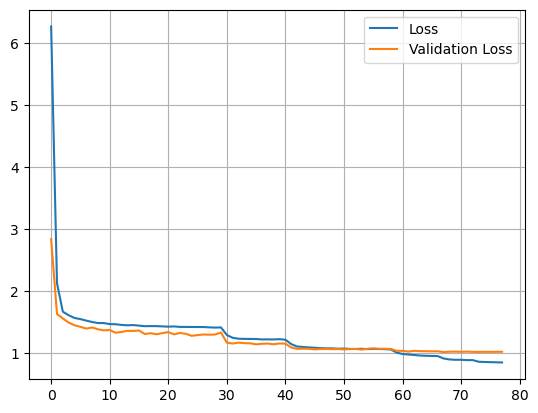

In [231]:
plt.plot(history.history["loss"], label="Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.grid()
plt.show()

In [232]:
test_scores = FCN_TOP.evaluate(X_test, y_test, verbose=0)
print(f"Test loss: {test_scores[0]:.2f}")
print(f"Test accuracy: {test_scores[1]:.2f}")

Test loss: 1.04
Test accuracy: 0.68


### Summary

In this notebook, I used the CIFAR-10 dataset to build a classifier by leveraging the VGG16 convolutional base for feature extraction. I experimented with several model architectures, but after multiple trials and only marginal progress, I decided to stop. To prevent overfitting and optimize training, I applied heavy regularization techniques such as EarlyStopping, ReduceLROnPlateau, L2 regularization, and Dropout.

The classifier achieved a test accuracy of nearly 70%, which is reasonable but still below the 80% test accuracy we reached with a custom model built from scratch in the Neuroverkkoprojekti course. A potential reason for the relatively lower performance could be the mismatch in image sizes, as CIFAR-10 images are 32x32 pixels while VGG16 was originally designed for 224x224 input images.